# Previsão do Preço do Bitcoin com LSTM
 
**Framework:** TensorFlow/Keras

**Requerimentos:** 

    1.Python 3.9
    2.Tensorflow
    3.Pandas
    4.Matplotlib

## Etapas do Projeto:
    1. Carregamento e Exploração dos Dados
    2. Pré-processamento
    3. Criação do Modelo LSTM
    4. Treinamento e Validação
    5. Avaliação e Previsões




# Importação de Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Carregamento e Exploração dos Dados

In [2]:
# Carregar o arquivo CSV (ajuste o caminho conforme necessário)
df = pd.read_csv('btcusd_1-min_data.csv')

In [3]:
df

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
1,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
2,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
3,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
4,1.325412e+09,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
6750276,1.737936e+09,102628.00,102669.00,102608.00,102611.00,0.086742
6750277,1.737936e+09,102659.00,102712.00,102657.00,102712.00,0.488757
6750278,1.737936e+09,102631.00,102631.00,102573.00,102573.00,0.126719
6750279,1.737936e+09,102573.00,102604.00,102507.00,102514.00,0.474495


In [4]:
# Converter timestamp para datetime
df['date'] = pd.to_datetime(df['Timestamp'], unit='s')
df.head()

,Timestamp,Open,High,Low,Close,Volume,date
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:01:00
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:02:00
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:03:00
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:04:00
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0,2012-01-01 10:05:00


In [5]:

print("\nInformações do Dataset:")
df.info()


Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6750281 entries, 0 to 6750280
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Timestamp  float64       
 1   Open       float64       
 2   High       float64       
 3   Low        float64       
 4   Close      float64       
 5   Volume     float64       
 6   date       datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 360.5 MB


## Pré-processamento Inicial

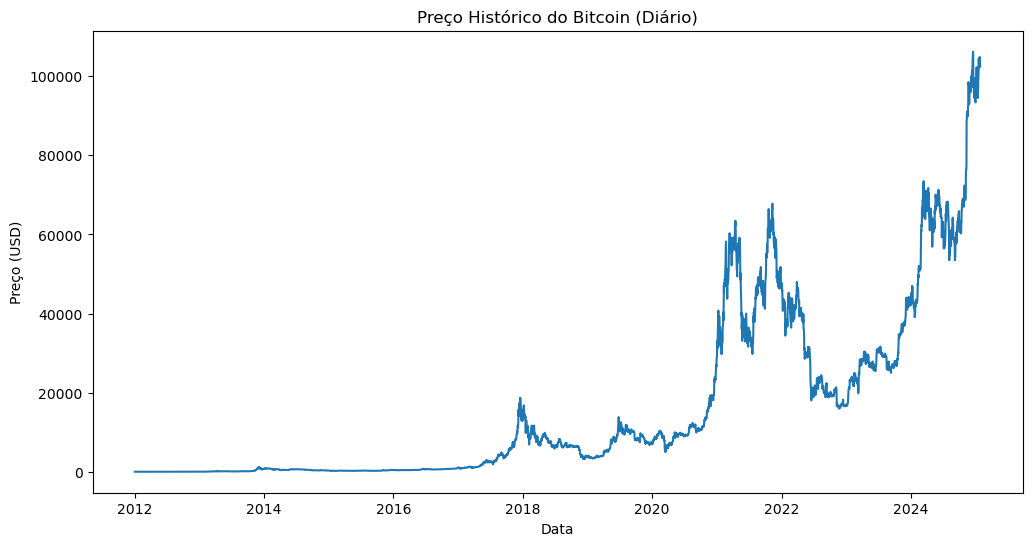

In [6]:
# Converter dados de 1 minuto para diários
df_daily = df.resample('D', on='date').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum',
    
}).dropna()

# Plot do preço de fechamento
plt.figure(figsize=(12,6))
plt.plot(df_daily.index, df_daily['Close'])
plt.title('Preço Histórico do Bitcoin (Diário)')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.show()

# 2. Pré-processamento para LSTM

In [7]:
# Usaremos apenas o preço de fechamento
data = df_daily[['Close']].values

# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Divisão entre treino e teste
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [8]:
# Função para criar sequências
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length-1):
        X.append(data[i:(i+seq_length), 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60  # Janela temporal de 60 dias
X_train, y_train = create_sequences(train_data, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, SEQ_LENGTH)

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# 3. Criação do Modelo LSTM

In [10]:
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(Dropout(0.3))

model.add(LSTM(50, return_sequences=False))
#model.add(Dropout(0.3))
model.add(Dense(30))  # Prevê múltiplos passos (30 dias por vez)
model.add(Dense(1))

c:\Users\Erick\anaconda3\envs\TF\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Visualizar arquitetura
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 150)        │        91,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,961 (519.38 KB)

 Trainable params: 132,961 (519.38 KB)

 Non-trainable params: 0 (0.00 B)

# 4. Treinamento do Modelo

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

Epoch 1/300


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 4.4574e-04 - val_loss: 0.0011
Epoch 2/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 2.6323e-05 - val_loss: 0.0011
Epoch 3/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 2.6841e-05 - val_loss: 0.0011
Epoch 4/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 2.1848e-05 - val_loss: 6.5061e-04
Epoch 5/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 2.1769e-05 - val_loss: 0.0016
Epoch 6/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 2.3032e-05 - val_loss: 6.3861e-04
Epoch 7/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 2.3261e-05 - val_loss: 0.0012
Epoch 8/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 1.9757e-05 - val_loss: 8.7416e-04
Epoch 9/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 1.4761e-05 - val_loss: 0.0012
Epoch 10/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 1.9997e-05 - val_loss: 0.0020
Epoch 11/300
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 1.4471e-05 - val_loss: 0.0020
Epoch 12

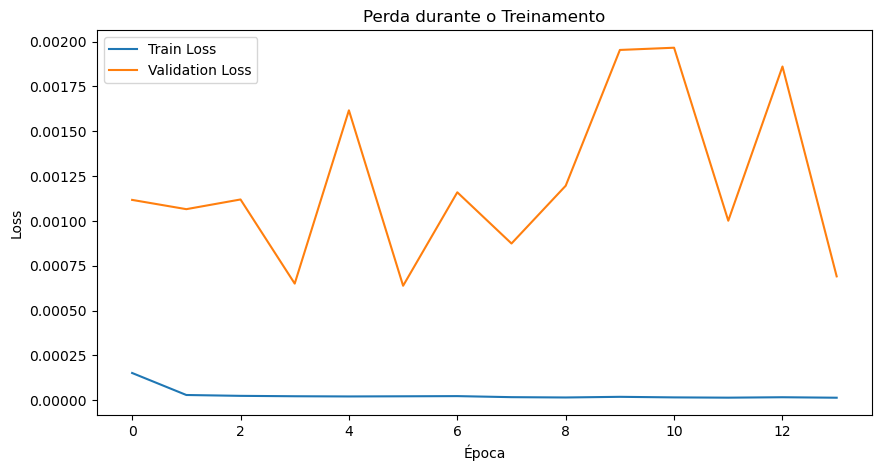

In [13]:
# Aumento de épocas e batch size
history = model.fit(
    X_train, y_train,
    epochs=300,          
    batch_size=32,       
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Plot da perda durante o treinamento
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Perda durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()




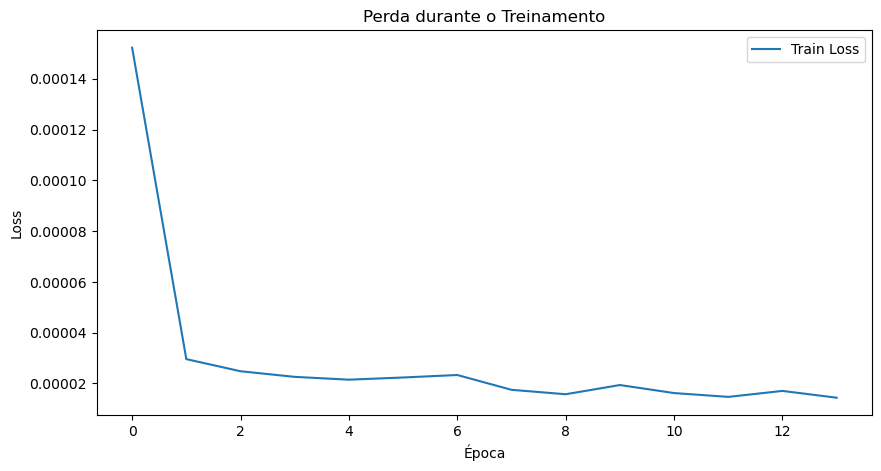

In [14]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Perda durante o Treinamento')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 5. Avaliação e Previsões

In [15]:
# Fazer previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Reverter a normalização
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform([y_test])



118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [16]:
# Deslocar as previsões de treino para alinhar visualmente
train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[SEQ_LENGTH:len(train_predict)+SEQ_LENGTH, :] = train_predict

In [17]:
# Deslocar as previsões de teste
test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(SEQ_LENGTH*2)+1:len(data)-1, :] = test_predict

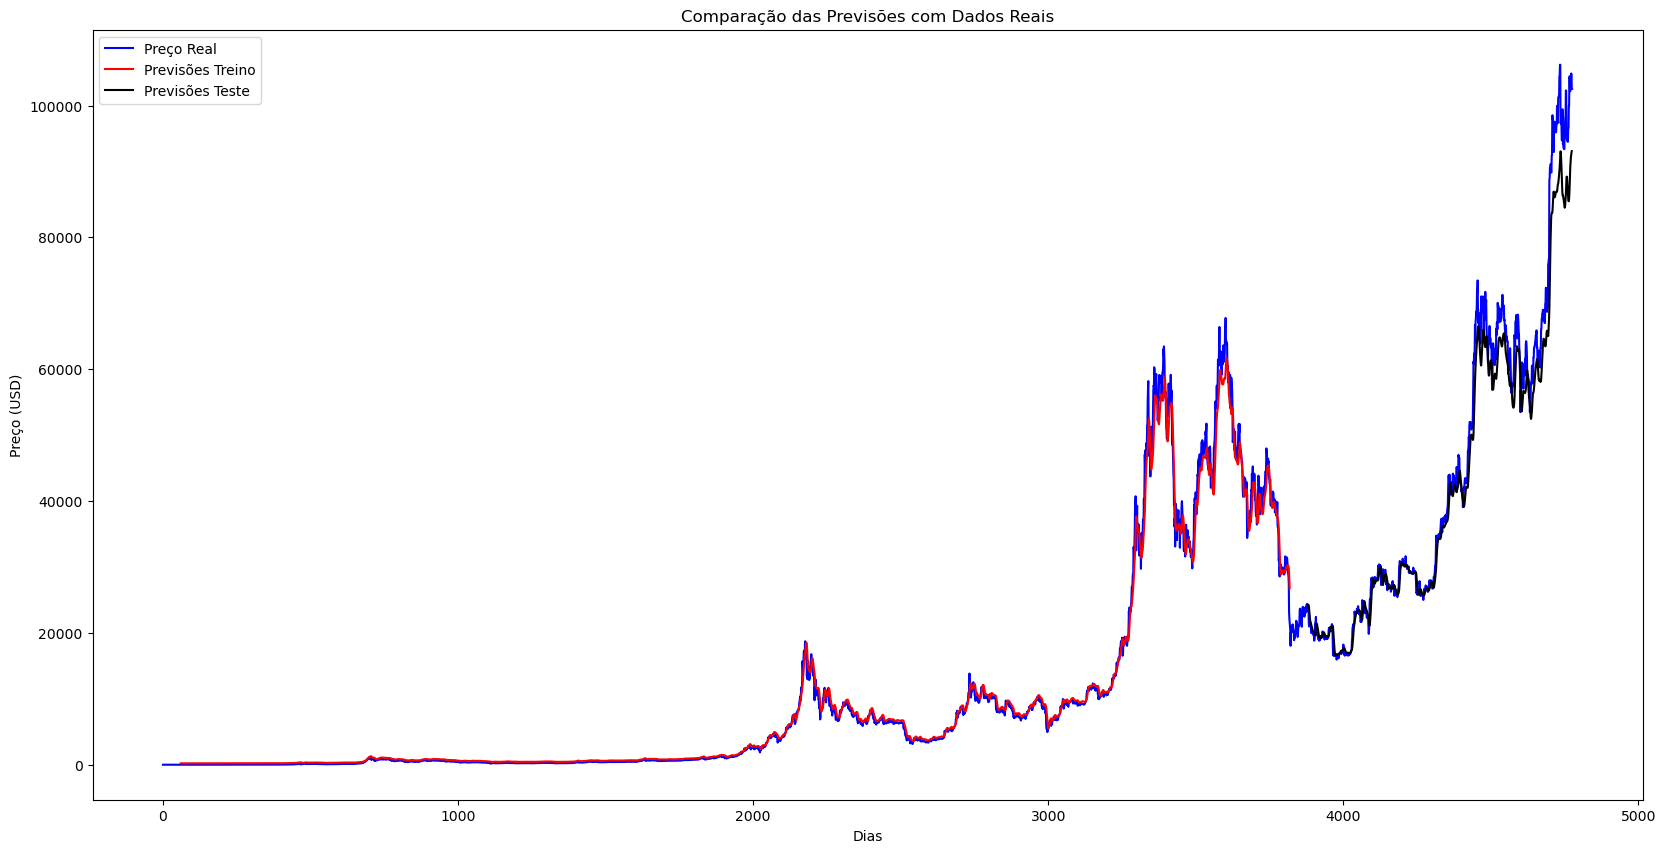

In [18]:
# Plotar tudo
# Plot dos resultados
plt.figure(figsize=(20,10))

plt.plot(data, label='Preço Real', color = 'blue')
plt.plot(train_plot, label='Previsões Treino', color = 'red')
plt.plot(test_plot, label='Previsões Teste', color= 'black')
plt.title('Comparação das Previsões com Dados Reais')
plt.xlabel('Dias')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

# Previsão Futura (Exemplo)

In [19]:
def predict_future(model, last_sequence, days=30):
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(days):
        # Fazer previsão
        next_pred = model.predict(current_sequence.reshape(1, SEQ_LENGTH, 1))
        
        # Atualizar a sequência
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred
        
        predictions.append(next_pred[0,0])
    
    return scaler.inverse_transform(np.array(predictions).reshape(-1,1))


In [20]:
# Última sequência dos dados de teste
last_sequence = scaled_data[-SEQ_LENGTH:]

# Gerar previsões para 30 dias
future_predictions = predict_future(model, last_sequence, days=365)
print("Previsões para os próximos 30 dias:")
print(future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

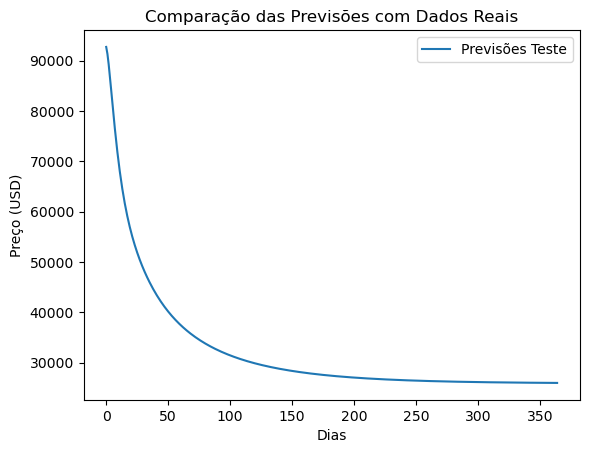

In [21]:
plt.plot(future_predictions, label='Previsões Teste')
plt.title('Comparação das Previsões com Dados Reais')
plt.xlabel('Dias')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()